<a href="https://colab.research.google.com/github/bharathkreddy/brks_agents/blob/main/finetuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [109]:
!pip install python-dotenv
!pip install datasets==3.6.0 # for ValueError: doesn't have a 'trust_remote_code' key. (load_dataset)

In [110]:
# imports

import os
from dotenv import load_dotenv
from huggingface_hub import login
from datasets import load_dataset, Dataset, DatasetDict
import matplotlib.pyplot as plt

In [111]:
from google.colab import userdata
HF_TOKEN = userdata.get('HUGGINGFACE_API_KEY')
login(HF_TOKEN, add_to_git_credential=True)

In [112]:
# data from https://huggingface.co/datasets/McAuley-Lab/Amazon-Reviews-2023

dataset = load_dataset("McAuley-Lab/Amazon-Reviews-2023", f"raw_meta_Appliances", split="full", trust_remote_code=True)

In [ ]:
for idx,item in enumerate(dataset):
  if idx>2:
    break
  print(item)

{'main_category': 'Industrial & Scientific', 'title': 'ROVSUN Ice Maker Machine Countertop, Make 44lbs Ice in 24 Hours, Compact & Portable Ice Maker with Ice Basket for Home, Office, Kitchen, Bar (Silver)', 'average_rating': 3.7, 'rating_number': 61, 'features': ['【Quick Ice Making】This countertop ice machine creates crystal & bullet shaped ice cubes; 44lbs of ice ready in 24 hours, 12 cubes made per cycle within 10 mins; you can perfectly use it for drinks, wine, smoothies, food', '【Portable Design】The weight of this ice maker is only 23.3lbs, and the small size (10.63 x14.37 x 12.87)" makes it portable. It\'s compact feature is perfect for home, office, apartments, dormitories, RVs and more, it can be placed on countertop or tabletop, plug it anywhere you like', '【Simple Operation】Adding the water tank with purified water; Power on machine and press "on/off" button to start ice making process; After 8-12 minutes, ice cube will fall off into the ice basket automatically; Take it out a

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### We want a subset of this dataset which has prices and item description. So lets check what % of the dataset has price field available. Note this is pyArrow table and not a list of dictionanries and hence we should use pyarrow based operations, I resisted the urge to load this on pandas dataframe to investigate as this would have eaten up my RAM.

In [154]:
import importlib
import items  # this assumes you've already imported it once
importlib.reload(items)
# i did above as i was constantly re-factoring items.py file but otherwise no need to reload the module as its an expensive operation
from items import Item  # re-import class from the updated module

In [155]:
items = []
for datapoint in dataset:
  try:
    price = float(datapoint["price"])
    if price > 0:
      item = Item(datapoint, price)
      items.append(item)
  except ValueError as e:
    pass

In [156]:
training_data = []
for item in items:
  if item.include:
    training_data.append(item)

In [158]:
len(items), len(training_data)

(46726, 42471)

(array([   0.,   56.,  838., 1396., 1219., 1475., 2461., 1832., 2020.,
        2217., 1625., 2352., 1312.,  900.,  788.,  863.,  878., 1163.,
        1050., 1423., 1314., 1044.,  932.,  802.,  888.,  911.,  765.,
         674.,  712.]),
 array([  0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.,
        110., 120., 130., 140., 150., 160., 170., 180., 190., 200., 210.,
        220., 230., 240., 250., 260., 270., 280., 290.]),
 <BarContainer object of 29 artists>)

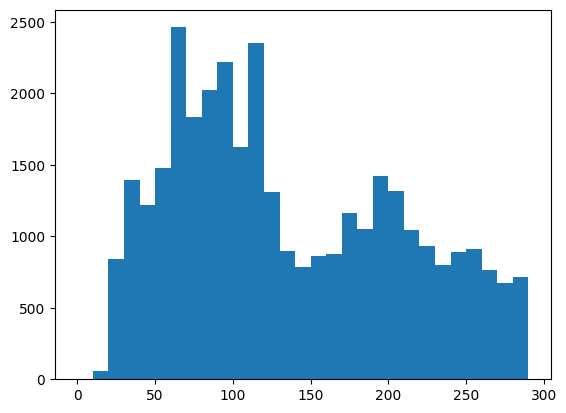

In [162]:
plt.hist([item.token_count for item in training_data], bins=range(0,300,10))

(array([ 5067., 10898.,  7582.,  4491.,  2564.,  1774.,  1355.,  1099.,
          851.,   753.,   495.,   475.,   412.,   349.,   327.,   284.,
          250.,   222.,   224.,   264.,   125.,   139.,   135.,   131.,
          138.,    91.,    98.,    91.,    60.]),
 array([  0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.,
        110., 120., 130., 140., 150., 160., 170., 180., 190., 200., 210.,
        220., 230., 240., 250., 260., 270., 280., 290.]),
 <BarContainer object of 29 artists>)

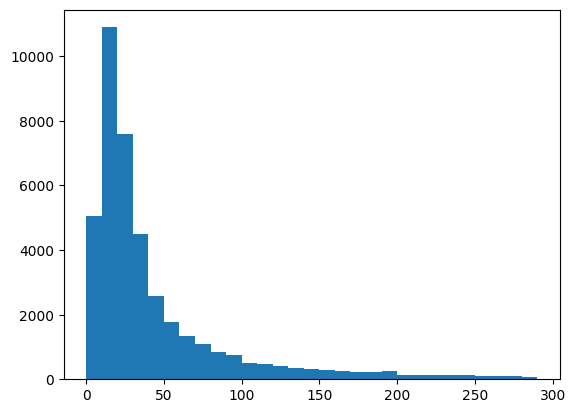

In [165]:
plt.hist([item.price for item in training_data], bins=range(0,300,10))

(array([ 5600., 11986.,  8245.,  4953.,  2814.,  1955.,  1499.,  1213.,
          959.,   851.,   558.,   521.,   452.,   377.,   359.,   307.,
          283.,   237.,   254.,   289.,   146.,   162.,   156.,   145.,
          153.,   100.,   111.,   100.,    69.]),
 array([  0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.,
        110., 120., 130., 140., 150., 160., 170., 180., 190., 200., 210.,
        220., 230., 240., 250., 260., 270., 280., 290.]),
 <BarContainer object of 29 artists>)

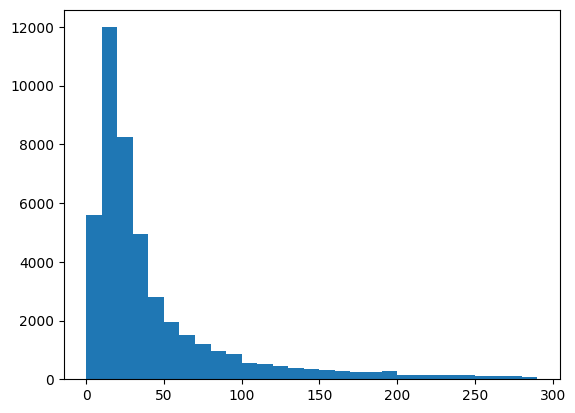

In [166]:
plt.hist([item.price for item in items], bins=range(0,300,10))

### Clearly we need to do a better job with data pre-precessing. Lets reattempt this.